# Classification using CLIP Emotion Classifier

In [1]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json

from collections import OrderedDict

import torch
import torch.nn as nn

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from pkg_resources import packaging

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\AlexTerentowicz\AppData\Local\Temp\ipykernel_7116\192567934.py:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


In [2]:
print("Torch version:", torch.__version__)
print(torch. cuda. is_available())
print("CUDA version:", torch.version.cuda)

Torch version: 2.3.0+cu118
True
CUDA version: 11.8


#### Load features

In [3]:
frame_types = ["frame_first", "frame_half", "frame_last", "comic_3", "comic_4"]
frame_type = frame_types[4]
path = f'./data/features/{frame_type}'
image_features = torch.load(f'{path}/image_features.pt')
text_features = torch.load(f'{path}/text_features.pt')

print(image_features.shape)
print(text_features.shape)

X = torch.cat((image_features, text_features), dim=1)
X.shape

torch.Size([13619, 512])
torch.Size([13619, 512])


torch.Size([13619, 1024])

#### Prepare lists of files and labels

In [4]:
with open('data/Subtask_2_train.json') as f:
    text_data_list = json.load(f)
    # text data is a map of conversation id to conversation
    text_data = {text['conversation_ID']: text for text in text_data_list}

# list of video filenames
video_fnames_list = []
n_utts = 0
labels = []

for c_id, conv in text_data.items():
    n_utts += len(conv['conversation'])
    for utt in conv['conversation']:
        # u_id = utt['utterance_ID']
        labels.append(utt['emotion'])
        video_fnames_list.append(utt['video_name'])

print(len(video_fnames_list), n_utts)

13619 13619


In [5]:
onehot_encoder = OneHotEncoder()
Y = onehot_encoder.fit_transform(np.array(labels).reshape(-1, 1))
Y = torch.tensor(Y.toarray()).cuda()
dict(enumerate(onehot_encoder.categories_[0]))

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'joy',
 4: 'neutral',
 5: 'sadness',
 6: 'surprise'}

Split the dataset

In [6]:
train_indices, test_indices = train_test_split(range(len(video_fnames_list)), test_size=0.2, random_state=42)

# lengths
print(len(train_indices), len(test_indices))

# create a list of video filenames, X_train, X_test, Y_train, Y_test

train_video_fnames = [video_fnames_list[i] for i in train_indices]
test_video_fnames = [video_fnames_list[i] for i in test_indices]

X_train, X_test = X[train_indices], X[test_indices]
Y_train, Y_test = Y[train_indices], Y[test_indices]

10895 2724


## Define model

In [7]:
model_name = 'simple-clip-emoclsf-9'

os.makedirs(f'./experiments/plots/{model_name}', exist_ok=True)

class ClipEmotionClassifier(nn.Module):
    def __init__(self):
        super(ClipEmotionClassifier, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.fc_in = nn.Linear(1024, 512)
        self.fc_out = nn.Linear(512, 7)

        # self.fc_in = nn.Linear(1024, 512)
        # self.fc_1 = nn.Linear(512, 512)
        # self.fc_out = nn.Linear(512, 7)

        # the original
        # self.dropout = nn.Dropout(0.2)
        # self.fc1 = nn.Linear(1024, 512)
        # self.fc2 = nn.Linear(512, 7)


    def forward(self, x):
        self.dropout = nn.Dropout(0.2)
        x = torch.relu(self.fc_in(x))
        x = self.fc_out(x)
        return x

In [8]:
model = ClipEmotionClassifier().cuda()
model

ClipEmotionClassifier(
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_in): Linear(in_features=1024, out_features=512, bias=True)
  (fc_out): Linear(in_features=512, out_features=7, bias=True)
)

## Train the model

In [9]:
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.rc('figure', figsize=(9, 5))

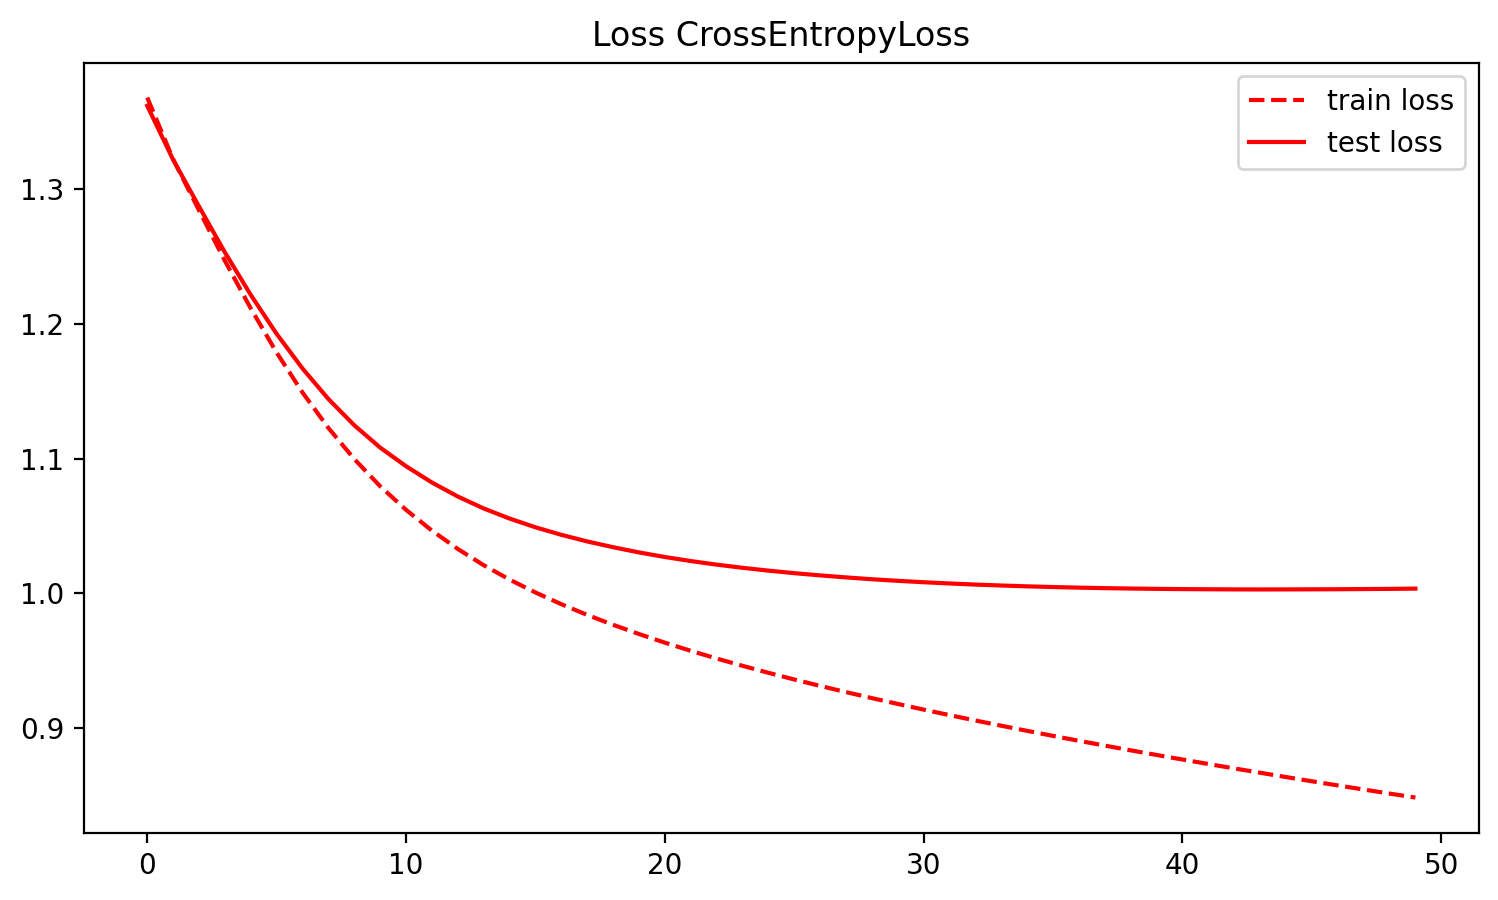

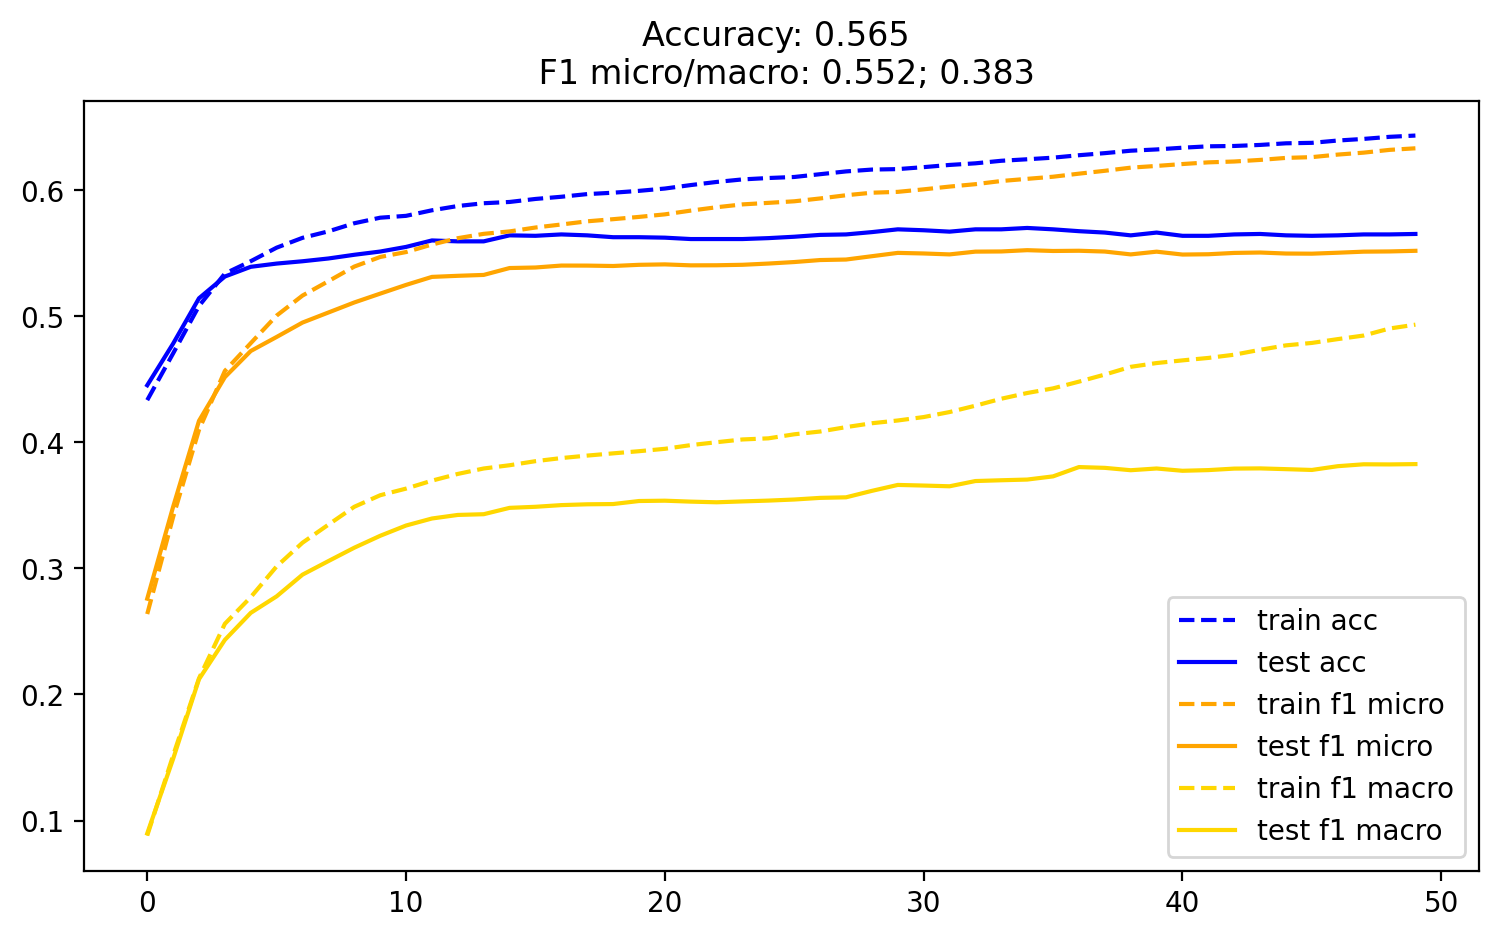

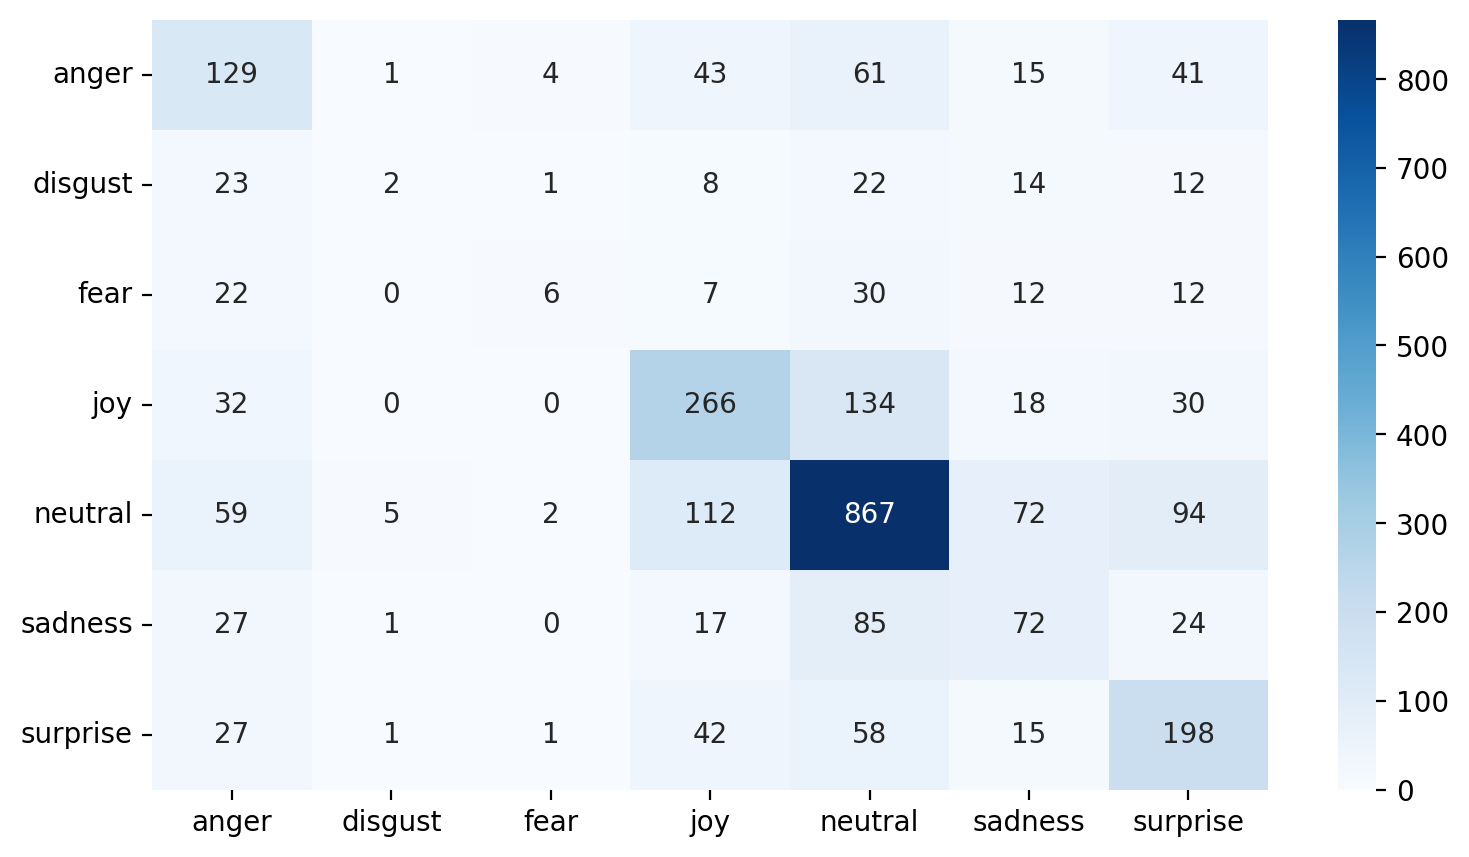

: 

In [10]:
# Define training parameters

model = ClipEmotionClassifier().cuda()
model

# cross-entropy loss
# criterion = nn.CrossEntropyLoss()

# weighted cross entropy loss
# weights = None
# weights = [len(Y) / float(c_count) for c_count in Y.sum(dim=0)]
weights = [1.0, 1.0, 1.0, 1.0, 0.7, 1.0, 1.0]
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).cuda())

# optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.8)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
# optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
# optimizer = optim.Adadelta(model.parameters(), lr=0.1)

n_epochs = 50
# batch_size = 128
batch_size = 256
n_batches = X_train.shape[0] // batch_size
train_losses, test_losses = [], [] 
train_accuracies, test_accuracies = [], []
train_f1_micro_scores, test_f1_micro_scores = [], []
train_f1_macro_scores, test_f1_macro_scores = [], []

# save training parameters in json
training_params = {
    'n_epochs': n_epochs,
    'batch_size': batch_size,
    'n_batches': n_batches,
    'optimizer': {
        'name': optimizer.__class__.__name__,
        'lr': optimizer.param_groups[0]['lr']
    },
    'criterion': criterion.__class__.__name__,
    'weights': weights,
    'regularization': 'dropout 0.2'
}
with open(f'./experiments/models/{model_name}.json', 'w') as f:
    json.dump(training_params, f)



for epoch in range(n_epochs):
    running_loss = 0.0
    for i in range(n_batches):
        optimizer.zero_grad()
        outputs = model(X_train[i*batch_size:(i+1)*batch_size])

        loss = criterion(outputs, torch.argmax(Y_train[i*batch_size:(i+1)*batch_size], dim=1))
        # print(loss.cpu().detach().numpy())
        
        loss.backward()
        optimizer.step()

        # if i % 10 == 9:
        #     print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10}")
        #     running_loss = 0.0
    
    with torch.no_grad():
        train_outputs = model(X_train)
        test_outputs = model(X_test)

        train_loss = criterion(train_outputs, Y_train.float()).cpu().numpy()
        test_loss = criterion(test_outputs, Y_test.float()).cpu().numpy()

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        clear_output(wait=True)
        
        plt.figure()
        plt.title(f'Loss {criterion.__class__.__name__}')
        plt.plot(train_losses, label='train loss', color='red', linestyle='dashed')
        plt.plot(test_losses, label='test loss', color='red')
        plt.legend()
        plt.savefig(f'./experiments/plots/{model_name}/{criterion.__class__.__name__}.png')
        plt.show()

        train_acc = torch.sum(torch.argmax(train_outputs, dim=1) == torch.argmax(Y_train, dim=1)).cpu().numpy() / len(Y_train)
        test_acc = torch.sum(torch.argmax(test_outputs, dim=1) == torch.argmax(Y_test, dim=1)).cpu().numpy() / len(Y_test)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # f1 micro scores
        train_f1_micro = f1_score(torch.argmax(Y_train.cpu(), dim=1), torch.argmax(train_outputs.cpu(), dim=1), average='weighted')
        test_f1_micro = f1_score(torch.argmax(Y_test.cpu(), dim=1), torch.argmax(test_outputs.cpu(), dim=1), average='weighted')
        train_f1_micro_scores.append(train_f1_micro)
        test_f1_micro_scores.append(test_f1_micro)

        # f1 macro scores
        train_f1_macro = f1_score(torch.argmax(Y_train.cpu(), dim=1), torch.argmax(train_outputs.cpu(), dim=1), average='macro')
        test_f1_macro = f1_score(torch.argmax(Y_test.cpu(), dim=1), torch.argmax(test_outputs.cpu(), dim=1), average='macro')
        train_f1_macro_scores.append(train_f1_macro)
        test_f1_macro_scores.append(test_f1_macro)


        plt.figure()
        plt.title(f'Accuracy: {np.round(test_acc, 3)} \n F1 micro/macro: {np.round(test_f1_micro, 3)}; {np.round(test_f1_macro, 3)}')
        plt.plot(train_accuracies, label='train acc', color='blue', linestyle='dashed')
        plt.plot(test_accuracies, label='test acc', color='blue')
        plt.plot(train_f1_micro_scores, label='train f1 micro', color='orange', linestyle='dashed')
        plt.plot(test_f1_micro_scores, label='test f1 micro', color='orange')
        plt.plot(train_f1_macro_scores, label='train f1 macro', color='gold', linestyle='dashed')
        plt.plot(test_f1_macro_scores, label='test f1 macro', color='gold')
        plt.legend()
        plt.savefig(f'./experiments/plots/{model_name}/AccuracyF1.png')
        plt.show()

        cm = confusion_matrix(torch.argmax(Y_test.cpu(), dim=1), torch.argmax(test_outputs.cpu(), dim=1))
        plt.figure()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=onehot_encoder.categories_[0], yticklabels=onehot_encoder.categories_[0])
        plt.savefig(f'./experiments/plots/{model_name}/confusion_matrix.png')
        plt.show()
        


# save final model
torch.save(model, f'./experiments/models/{model_name}.pt')

### Additional exploration for classification using GPT-4o API - count the number of total frames and seconds in the test dataset

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def vid_path(filename):
    return f'.\\data\\video\\train_all\\{filename}'

def load_video(filename):
    cap = cv2.VideoCapture(filename)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

# print(len(os.listdir('./data/video/train/')))
print(len(os.listdir('.\\data\\video\\train_all\\')))


13619


In [35]:
# analysis of video lengths in the test dataset

test_video_lengths = []
test_seconds = []

for i_c, conv in enumerate(text_data_list):
    if i_c % 100 == 0:
        print(f"Processing conversation {i_c}/{len(text_data)}")
    for utt in conv['conversation']:
        if utt['video_name'] not in test_video_fnames:
            continue
        vid = load_video(vid_path(utt['video_name']))
        test_video_lengths.append(len(vid))
        test_seconds.append(len(vid)/cv2.VideoCapture(vid_path(utt['video_name'])).get(cv2.CAP_PROP_FPS))

Processing conversation 0/1374
Processing conversation 100/1374
Processing conversation 200/1374
Processing conversation 300/1374
Processing conversation 400/1374
Processing conversation 500/1374
Processing conversation 600/1374
Processing conversation 700/1374
Processing conversation 800/1374
Processing conversation 900/1374
Processing conversation 1000/1374
Processing conversation 1100/1374
Processing conversation 1200/1374
Processing conversation 1300/1374
Total frames & seconds:  204045 8508.83191218778


Total frames & seconds:  204045 8508.83191218778


Text(0.5, 1.0, 'Number of frames per video')

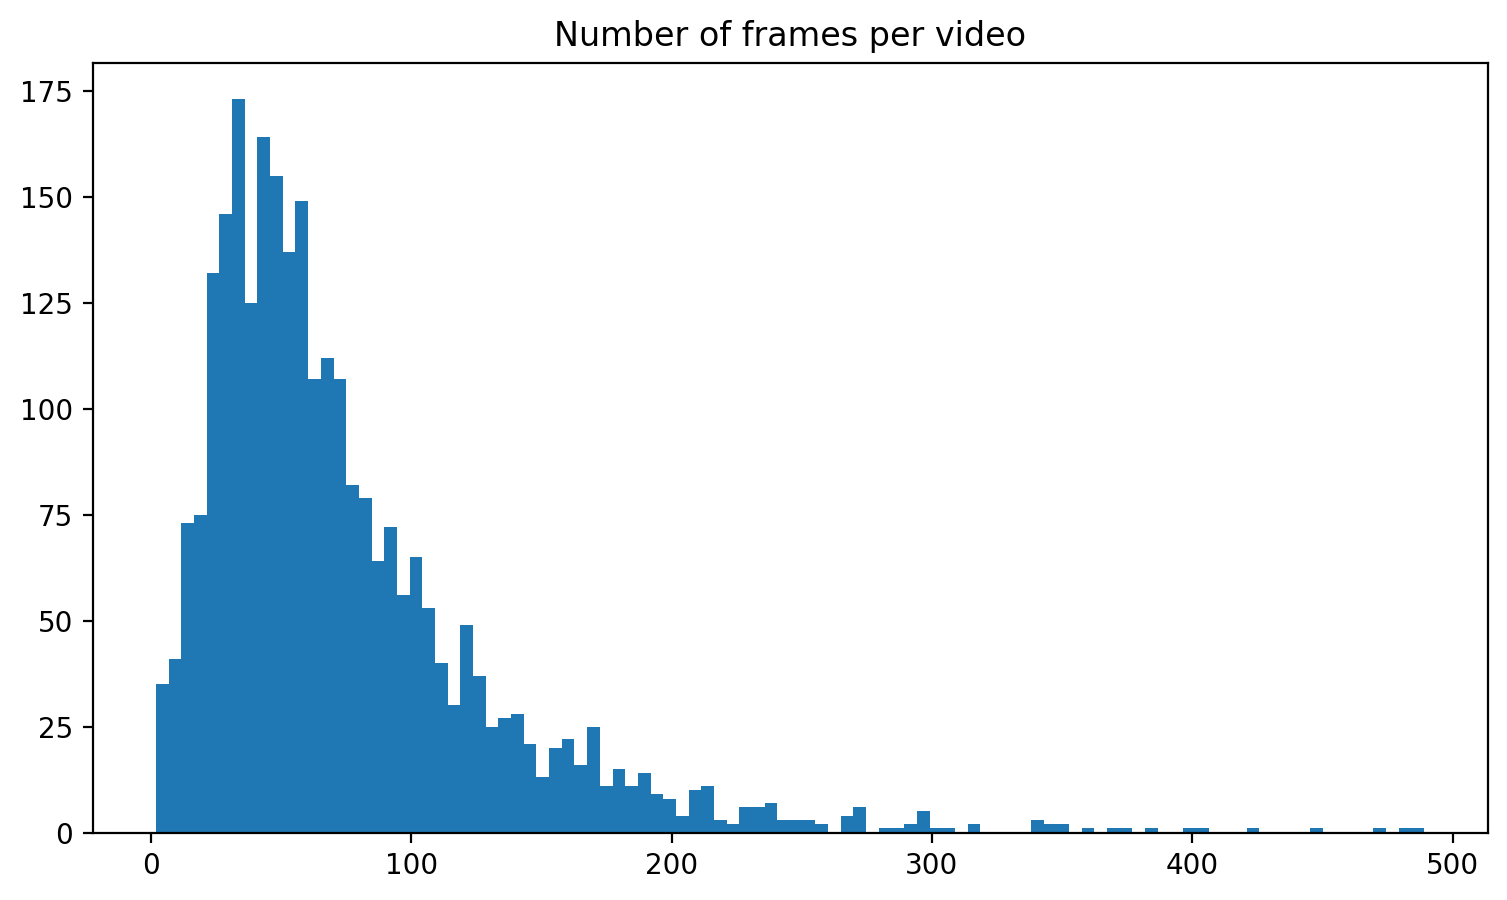

In [40]:
# print sums
print("Total frames & seconds: ", sum(test_video_lengths), sum(test_seconds))

# print histograms for number of frames and seconds per video
plt.hist(test_video_lengths, bins=100)
plt.title('Number of frames per video')

Text(0.5, 1.0, 'Number of seconds per video')

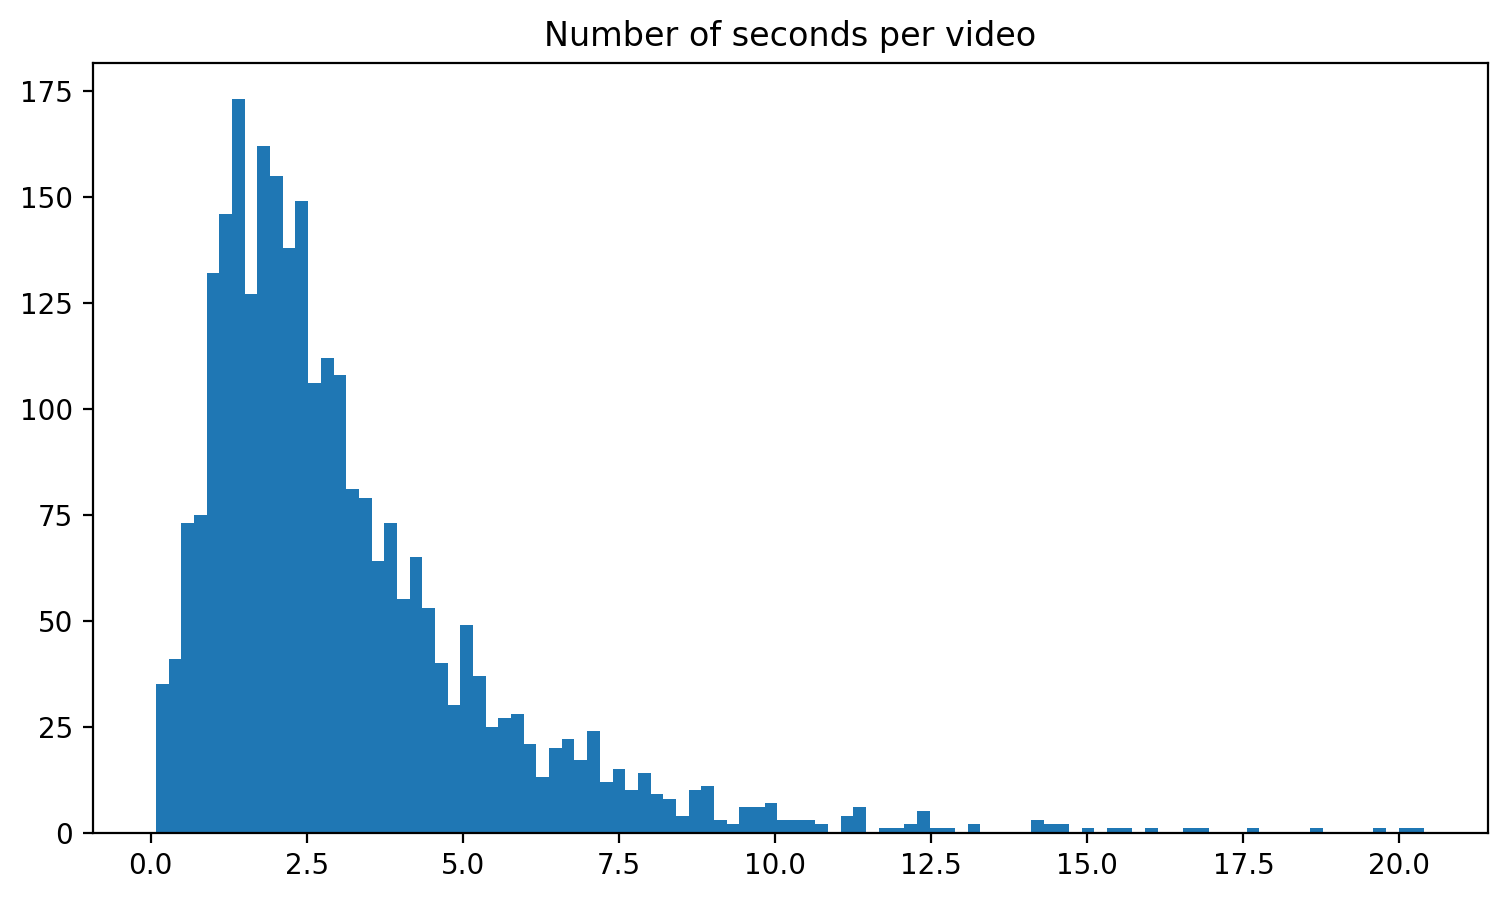

In [41]:
plt.hist(test_seconds, bins=100)
plt.title('Number of seconds per video')

Given every 10th frame, we're left with 20404 frames

In [52]:
# GPT-4o-2024-08-06
price_per_1m_tokens = 2.50
price_per_token = price_per_1m_tokens / 1000000
prompt_len = 200  # in tokens
price_full_px = 0.002763

no_videos = len(test_video_fnames)

frames = 204045

print("Price for prompts: ", prompt_len * price_per_token * no_videos)

vid_price = price_full_px * frames
print("Best quality video price: ", vid_price)

price_640x360 = 0.001063

every_nth_frame = 10
frames = frames // every_nth_frame

vid_price = price_640x360 * frames
print("Worse quality video price: ", vid_price)

Price for prompts:  1.362
Best quality video price:  563.776335
Worse quality video price:  21.689452
